<a href="https://colab.research.google.com/github/V3ct4r31/TelecomX_challenge2/blob/main/Telecom_X_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**TELECOM X**
##**"CHURN DE CLIENTES"**
###**Introducción**
La empresa Telecom X es una empresa de telecomunicaciones que está enfrentando un alto índice de evasión de clientes (alta tasa de cancelaciones) y aún no han identificado el problema de esta pérdida de clientes. Por esta razón, deciden iniciar un proyecto específico de Churn de clientes. Para ello, se nos ha proporcionado datos de la empresa para realizar el análisis exploratorio de ellos para posteriormente entregarlos al equipo de ciencia de datos, quienes realizarán el análisis predictivo que determinará que factores contribuyen a esta evasión de clientes.

##**Exploración de datos Telecom X**

In [1]:
import pandas as pd
import numpy as np

datos = pd.read_json('/content/TelecomX_Data.json')
datos.head()

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


In [2]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7267 non-null   object
 1   Churn       7267 non-null   object
 2   customer    7267 non-null   object
 3   phone       7267 non-null   object
 4   internet    7267 non-null   object
 5   account     7267 non-null   object
dtypes: object(6)
memory usage: 340.8+ KB


In [3]:
datos.describe()

,customerID,Churn,customer,phone,internet,account
count,7267,7267,7267,7267,7267,7267
unique,7267,3,891,3,129,6931
top,9995-HOTOH,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'No', 'OnlineSecurity': 'N...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
freq,1,5174,223,3495,1581,6


In [4]:
datos.columns

Index(['customerID', 'Churn', 'customer', 'phone', 'internet', 'account'], dtype='object')

##**Limpieza y transformación de datos**

In [5]:
customer_df = pd.json_normalize(datos['customer'])
phone_df = pd.json_normalize(datos['phone'])
internet_df = pd.json_normalize(datos['internet'])
account_df = pd.json_normalize(datos['account'])

df_expanded = pd.concat([
    datos[['customerID', 'Churn']],
    customer_df,
    phone_df,
    internet_df,
    account_df
], axis=1)

# 2. Limpieza de la columna 'Churn'
df_expanded['Churn'] = df_expanded['Churn'].replace('', 'No')
df_expanded['Churn'] = df_expanded['Churn'].map({'Yes': 1, 'No': 0})

# 3. Mapeo de columnas de servicio de internet y teléfono
internet_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in internet_cols:
    df_expanded[col] = df_expanded[col].map({'Yes': 1, 'No': 0, 'No internet service': 0})

df_expanded['MultipleLines'] = df_expanded['MultipleLines'].map({'Yes': 1, 'No': 0, 'No phone service': 0})

# 4. Mapeo de otras columnas binarias (gender, Partner, etc.)
mapeo_binario = {'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0}
columnas_a_mapear = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in columnas_a_mapear:
    df_expanded[col] = df_expanded[col].map(mapeo_binario)

# 5. Mapeo de columnas categóricas con múltiples valores
mapeo_contrato = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
df_expanded['Contract'] = df_expanded['Contract'].map(mapeo_contrato)

mapeo_internet = {'Fiber optic': 0, 'DSL': 1, 'No': 2}
df_expanded['InternetService'] = df_expanded['InternetService'].map(mapeo_internet)

mapeo_pago = {'Electronic check': 0, 'Mailed check': 1, 'Bank transfer (automatic)': 2, 'Credit card (automatic)': 3}
df_expanded['PaymentMethod'] = df_expanded['PaymentMethod'].map(mapeo_pago)

# 6. Limpieza de las columnas de cargos
df_expanded['Charges.Total'] = pd.to_numeric(df_expanded['Charges.Total'], errors='coerce')
df_expanded['Charges.Total'] = df_expanded['Charges.Total'].fillna(0)

# 7. Finalmente, verifica el resultado
df_expanded.head()
df_expanded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   int64  
 2   gender            7267 non-null   int64  
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   int64  
 5   Dependents        7267 non-null   int64  
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   int64  
 8   MultipleLines     7267 non-null   int64  
 9   InternetService   7267 non-null   int64  
 10  OnlineSecurity    7267 non-null   int64  
 11  OnlineBackup      7267 non-null   int64  
 12  DeviceProtection  7267 non-null   int64  
 13  TechSupport       7267 non-null   int64  
 14  StreamingTV       7267 non-null   int64  
 15  StreamingMovies   7267 non-null   int64  
 16  Contract          7267 non-null   int64  


In [7]:
df_expanded.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,0,0,0,1,1,9,1,0,1,...,1,0,1,1,0,1,1,1,65.6,593.30
1,0003-MKNFE,0,1,0,0,0,9,1,1,1,...,0,0,0,0,1,0,0,1,59.9,542.40
2,0004-TLHLJ,1,1,0,0,0,4,1,0,0,...,0,1,0,0,0,0,1,0,73.9,280.85
3,0011-IGKFF,1,1,1,1,0,13,1,0,0,...,1,1,0,1,1,0,1,0,98.0,1237.85
4,0013-EXCHZ,1,0,1,1,0,3,1,0,0,...,0,0,1,1,0,0,1,1,83.9,267.40


In [51]:
df_expanded.to_csv("datos_tratados.csv", index=False)

##**Revisión de la transformación y estandarización de datos del Dataframe**

In [8]:
df_expanded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   int64  
 2   gender            7267 non-null   int64  
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   int64  
 5   Dependents        7267 non-null   int64  
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   int64  
 8   MultipleLines     7267 non-null   int64  
 9   InternetService   7267 non-null   int64  
 10  OnlineSecurity    7267 non-null   int64  
 11  OnlineBackup      7267 non-null   int64  
 12  DeviceProtection  7267 non-null   int64  
 13  TechSupport       7267 non-null   int64  
 14  StreamingTV       7267 non-null   int64  
 15  StreamingMovies   7267 non-null   int64  
 16  Contract          7267 non-null   int64  


In [9]:
df_expanded.describe()

,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
count,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000
mean,0.257190,0.505711,0.162653,0.484106,0.300124,32.346498,0.902711,0.421770,0.777487,0.285950,0.344571,0.342782,0.289528,0.383927,0.387505,0.688730,0.593230,1.313747,64.720098,2277.182035
std,0.437115,0.500002,0.369074,0.499782,0.458343,24.571773,0.296371,0.493876,0.779873,0.451897,0.475261,0.474672,0.453575,0.486374,0.487214,0.833174,0.491265,1.148885,30.129572,2268.648587
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.425000,396.200000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,70.300000,1389.200000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,89.875000,3778.525000
max,1.000000,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,118.750000,8684.800000


In [10]:
df_expanded.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,0,0,0,1,1,9,1,0,1,...,1,0,1,1,0,1,1,1,65.6,593.30
1,0003-MKNFE,0,1,0,0,0,9,1,1,1,...,0,0,0,0,1,0,0,1,59.9,542.40
2,0004-TLHLJ,1,1,0,0,0,4,1,0,0,...,0,1,0,0,0,0,1,0,73.9,280.85
3,0011-IGKFF,1,1,1,1,0,13,1,0,0,...,1,1,0,1,1,0,1,0,98.0,1237.85
4,0013-EXCHZ,1,0,1,1,0,3,1,0,0,...,0,0,1,1,0,0,1,1,83.9,267.40


#**Preparación del conjunto de datos para el modelado**

In [11]:
# Crea una copia del DataFrame como punto de control
df_modelado = df_expanded.copy()

# Elimina las columnas 'customerID' y 'Churn' para crear las variables independientes (X)
X = df_modelado.drop(columns=['customerID', 'Churn'])

# Asigna la columna 'Churn' como la variable dependiente (y)
y = df_modelado['Churn']

print("Variables independientes (X) listas.")
print("Variable objetivo (y) lista.")

Variables independientes (X) listas.
Variable objetivo (y) lista.


In [12]:
from sklearn.model_selection import train_test_split

# Divide los datos en un 80% para entrenamiento y un 20% para prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Opcional: Verifica las dimensiones de los conjuntos
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de X_test:", X_test.shape)
print("Dimensiones de y_test:", y_test.shape)

Dimensiones de X_train: (5813, 19)
Dimensiones de y_train: (5813,)
Dimensiones de X_test: (1454, 19)
Dimensiones de y_test: (1454,)


##**Verificar la proporción de Churn**

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Supongo que X e y ya están definidos y limpios
# X = df_expanded.drop(columns=['customerID', 'Churn'])
# y = df_expanded['Churn']

# Dividir los datos
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar la proporción en el conjunto de entrenamiento
print("Distribución de la variable 'Churn' en el conjunto de entrenamiento:")
print(y_train.value_counts(normalize=True))

Distribución de la variable 'Churn' en el conjunto de entrenamiento:
Churn
0    0.742474
1    0.257526
Name: proportion, dtype: float64


##**Balanceo de datos (oversampling)**

In [14]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Inicializa el objeto SMOTE
smote = SMOTE(random_state=42)

# Aplica SMOTE solo a tus datos de entrenamiento
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Opcional: Verifica el conteo de la variable 'Churn' después de aplicar SMOTE
print("Conteo de 'Churn' en el conjunto de entrenamiento original:", Counter(y_train))
print("Conteo de 'Churn' en el conjunto de entrenamiento balanceado:", Counter(y_train_balanced))

Conteo de 'Churn' en el conjunto de entrenamiento original: Counter({0: 4316, 1: 1497})
Conteo de 'Churn' en el conjunto de entrenamiento balanceado: Counter({0: 4316, 1: 4316})


##**Entrenamiento de modelos**
(RamdomForest/Árbol de decisiones)

In [15]:
from sklearn.tree import DecisionTreeClassifier

# Inicializa el modelo con un estado aleatorio para resultados reproducibles
arbol_de_decisiones = DecisionTreeClassifier(random_state=42)

# Entrena el modelo con los datos balanceados
arbol_de_decisiones.fit(X_train_balanced, y_train_balanced)

print("Modelo de Árbol de Decisiones entrenado.")

Modelo de Árbol de Decisiones entrenado.


In [16]:
from sklearn.ensemble import RandomForestClassifier

# Inicializa el modelo con un estado aleatorio para resultados reproducibles
random_forest = RandomForestClassifier(random_state=42)

# Entrena el modelo con los datos balanceados
random_forest.fit(X_train_balanced, y_train_balanced)

print("Modelo de Random Forest entrenado.")

Modelo de Random Forest entrenado.


In [17]:
# Predicciones para el modelo de Árbol de Decisiones
y_pred_arbol = arbol_de_decisiones.predict(X_test)

# Predicciones para el modelo de Random Forest
y_pred_random_forest = random_forest.predict(X_test)

In [18]:
from sklearn.metrics import classification_report

# Reporte de clasificación para el Árbol de Decisiones
print("--- Reporte del Árbol de Decisiones ---")
print(classification_report(y_test, y_pred_arbol))

# Reporte de clasificación para el Random Forest
print("\n--- Reporte del Random Forest ---")
print(classification_report(y_test, y_pred_random_forest))

--- Reporte del Árbol de Decisiones ---
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1082
           1       0.47      0.55      0.50       372

    accuracy                           0.73      1454
   macro avg       0.65      0.67      0.66      1454
weighted avg       0.74      0.73      0.73      1454


--- Reporte del Random Forest ---
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1082
           1       0.55      0.60      0.58       372

    accuracy                           0.77      1454
   macro avg       0.71      0.72      0.71      1454
weighted avg       0.78      0.77      0.78      1454



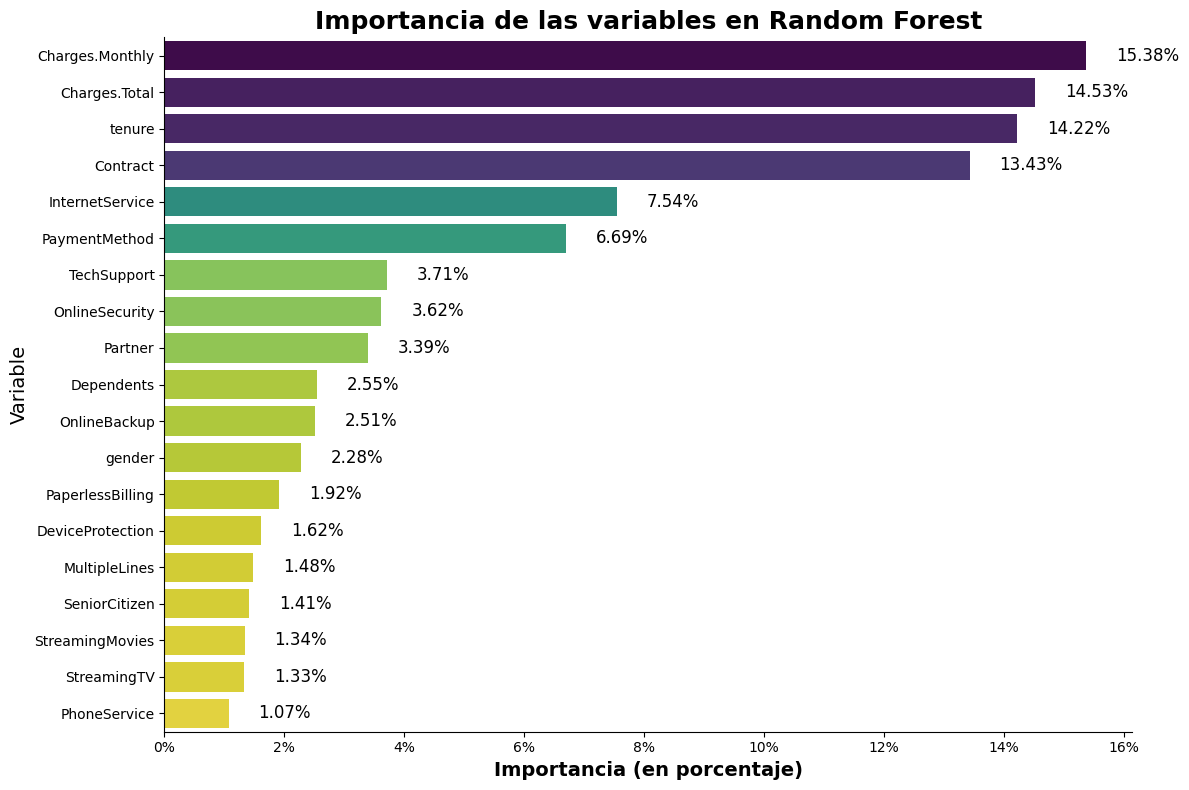

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Crear el DataFrame de importancia de las variables y ordenarlo
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': random_forest.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False).reset_index(drop=True)

# Personalizar el gráfico
plt.figure(figsize=(12, 8))

# Usar una paleta de colores de azul oscuro a claro, asignada a la importancia
# La paleta 'viridis' es excelente para este tipo de visualización
ax = sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis_r', hue='importance', legend=False)

# Personalizar el título
plt.title('Importancia de las variables en Random Forest', fontsize=18, fontweight='bold')

# Personalizar las etiquetas
plt.xlabel('Importancia (en porcentaje)', fontsize=14, fontweight='bold')
plt.ylabel('Variable', fontsize=14)

# Formatear el eje x para mostrar porcentajes
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f'{x*100:.0f}%'))

# Quitar las líneas superior y derecha del gráfico
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Asegúrate de que los valores de importancia se muestren correctamente
for index, row in feature_importances.iterrows():
    ax.text(row.importance + 0.005, index, f'{row.importance*100:.2f}%', va='center', fontsize=12)

#Cambiar el tamaño de la figura
plt.tight_layout()

# Guardar el gráfico como un archivo PNG
plt.savefig('importancia_de_variables_random_forest.png')

# Mostrar el gráfico
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

##**Estandarización de datos para Regresión lineal**

In [24]:
from sklearn.preprocessing import StandardScaler

# Inicializa el escalador
scaler = StandardScaler()

# Aplica la estandarización a tus datos de entrenamiento y prueba
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

print("Datos estandarizados listos.")

Datos estandarizados listos.


In [25]:
from sklearn.linear_model import LogisticRegression

# Inicializa el modelo
logreg = LogisticRegression(random_state=42)

# Entrena el modelo con los datos balanceados y estandarizados
logreg.fit(X_train_scaled, y_train_balanced)

print("Modelo de Regresión Logística entrenado.")

Modelo de Regresión Logística entrenado.


In [26]:
# Predicciones para el modelo de Regresión Logística
y_pred_logreg = logreg.predict(X_test_scaled)

In [27]:
from sklearn.metrics import classification_report

# Reporte de clasificación para la Regresión Logística
print("--- Reporte de la Regresión Logística ---")
print(classification_report(y_test, y_pred_logreg))

--- Reporte de la Regresión Logística ---
              precision    recall  f1-score   support

           0       0.88      0.80      0.83      1082
           1       0.53      0.68      0.60       372

    accuracy                           0.77      1454
   macro avg       0.71      0.74      0.72      1454
weighted avg       0.79      0.77      0.77      1454



In [28]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Asegúrate de que las predicciones ya han sido generadas
# y_pred_arbol = arbol_de_decisiones.predict(X_test)
# y_pred_random_forest = random_forest.predict(X_test)
# y_pred_logreg = logreg.predict(X_test_scaled) # Recuerda usar los datos estandarizados

# Calcular las métricas para cada modelo
precision_arbol = precision_score(y_test, y_pred_arbol, pos_label=1)
recall_arbol = recall_score(y_test, y_pred_arbol, pos_label=1)
f1_arbol = f1_score(y_test, y_pred_arbol, pos_label=1)

precision_rf = precision_score(y_test, y_pred_random_forest, pos_label=1)
recall_rf = recall_score(y_test, y_pred_random_forest, pos_label=1)
f1_rf = f1_score(y_test, y_pred_random_forest, pos_label=1)

precision_logreg = precision_score(y_test, y_pred_logreg, pos_label=1)
recall_logreg = recall_score(y_test, y_pred_logreg, pos_label=1)
f1_logreg = f1_score(y_test, y_pred_logreg, pos_label=1)

# Crear el DataFrame de comparación
data = {
    'Modelo': ['Random Forest', 'Árbol de Decisiones', 'Regresión Logística'],
    'Precisión (Clase 1)': [precision_rf, precision_arbol, precision_logreg],
    'Recall (Clase 1)': [recall_rf, recall_arbol, recall_logreg],
    'F1-Score (Clase 1)': [f1_rf, f1_arbol, f1_logreg]
}

df_comparacion = pd.DataFrame(data)

# Formatear las columnas numéricas para mostrar 2 decimales
df_comparacion['Precisión (Clase 1)'] = df_comparacion['Precisión (Clase 1)'].round(2)
df_comparacion['Recall (Clase 1)'] = df_comparacion['Recall (Clase 1)'].round(2)
df_comparacion['F1-Score (Clase 1)'] = df_comparacion['F1-Score (Clase 1)'].round(2)

print("Tabla de Comparación de Modelos:")
df_comparacion

Tabla de Comparación de Modelos:


,Modelo,Precisión (Clase 1),Recall (Clase 1),F1-Score (Clase 1)
0,Random Forest,0.55,0.60,0.58
1,Árbol de Decisiones,0.47,0.55,0.50
2,Regresión Logística,0.53,0.68,0.60


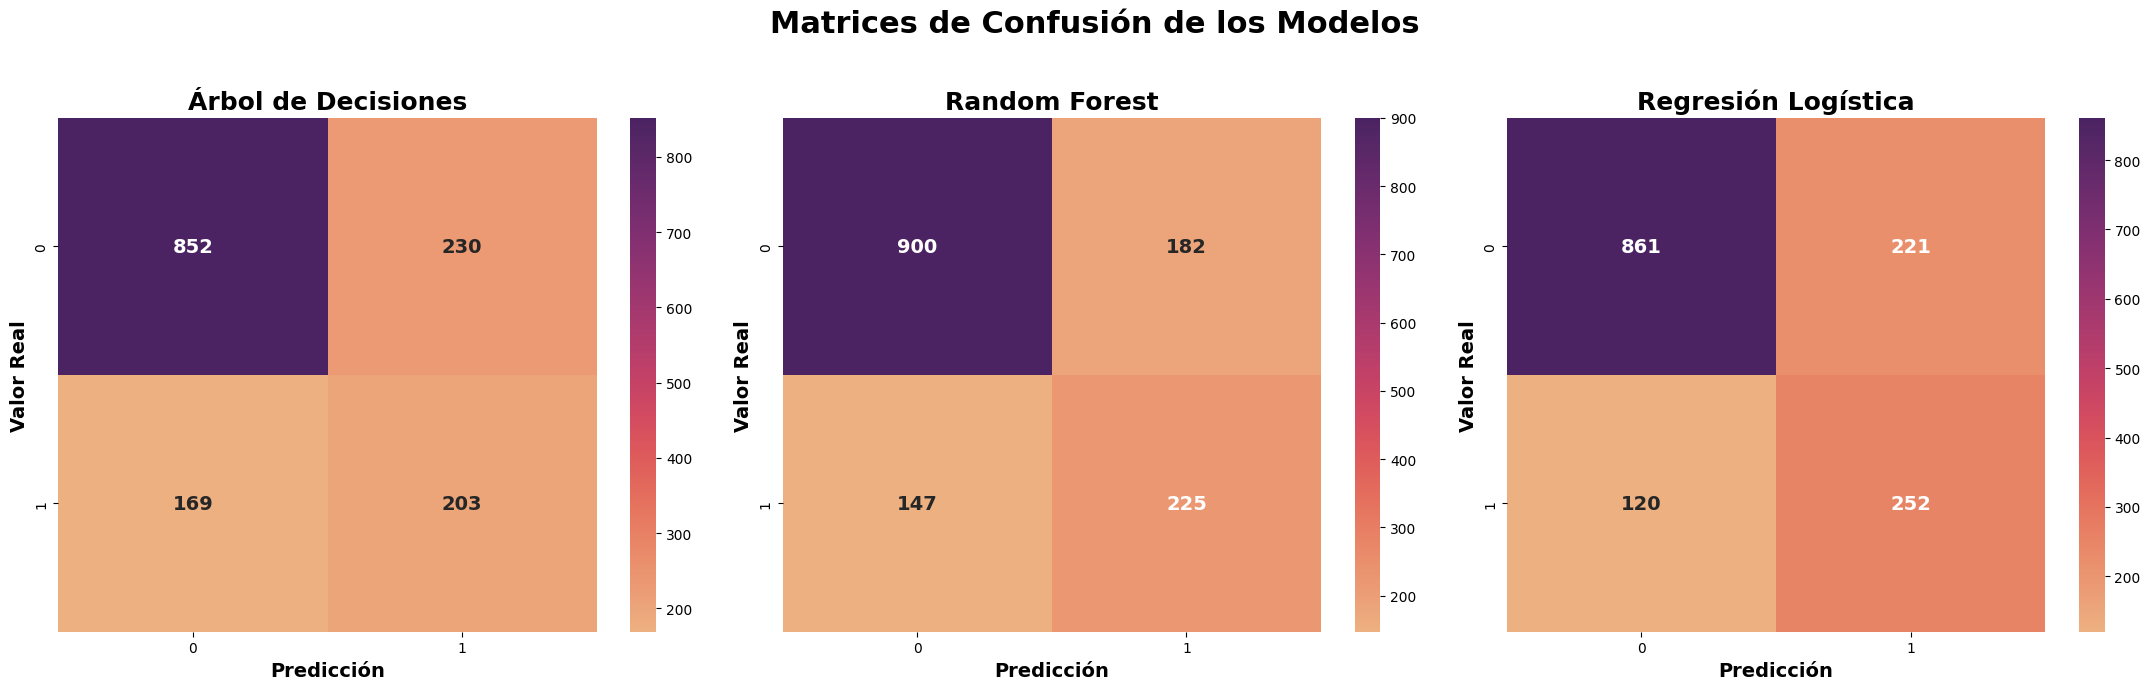

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title, ax):
    """Función para graficar la matriz de confusión."""
    cm = confusion_matrix(y_true, y_pred)
    # Cambiamos el tamaño de la fuente para los números dentro del gráfico y la ponemos en negrita
    sns.heatmap(cm, annot=True, fmt='d', cmap='flare', annot_kws={"fontsize":14, "fontweight":'bold'}, ax=ax)
    ax.set_title(title, fontsize=18, fontweight='bold')
    ax.set_xlabel('Predicción', fontsize=14, fontweight='bold')
    ax.set_ylabel('Valor Real', fontsize=14, fontweight='bold')

# Crear una figura con tres subgráficos
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7))

# Título general de la figura
fig.suptitle('Matrices de Confusión de los Modelos', fontsize=22, fontweight='bold')

# Matriz de Confusión para el Árbol de Decisiones
plot_confusion_matrix(y_test, y_pred_arbol, 'Árbol de Decisiones', ax1)

# Matriz de Confusión para el Random Forest
plot_confusion_matrix(y_test, y_pred_random_forest, 'Random Forest', ax2)

# Matriz de Confusión para la Regresión Logística
plot_confusion_matrix(y_test, y_pred_logreg, 'Regresión Logística', ax3)

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Guardar el gráfico como un archivo PNG
plt.savefig('matrices_de_confusion.png')

plt.show()

##**Importancia de variables en Ramdom Forest**

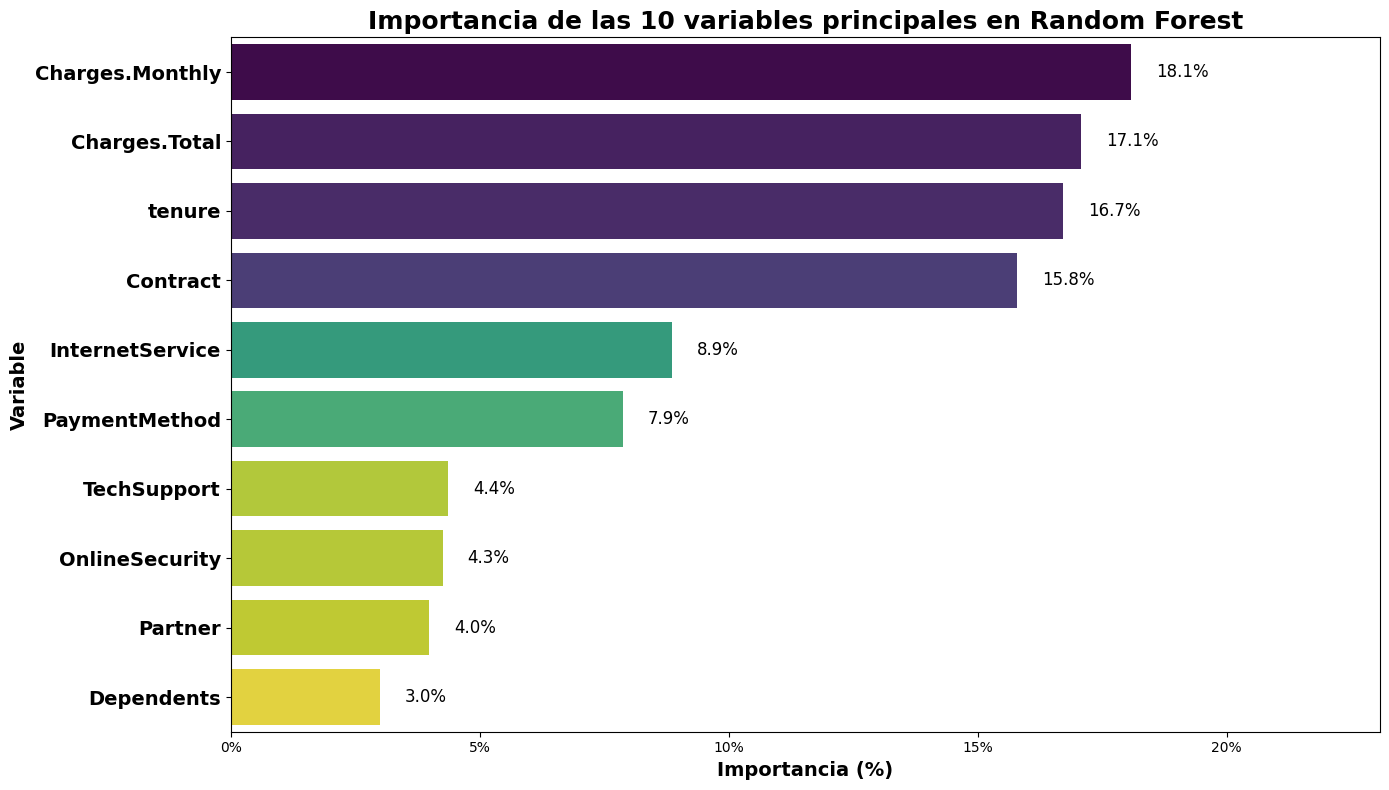

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener la importancia de las variables del modelo Random Forest
feature_importances = pd.DataFrame(
    {'feature': X_train.columns, 'importance': random_forest.feature_importances_}
).sort_values('importance', ascending=False).head(10)

# Calcular los porcentajes
total_importance = feature_importances['importance'].sum()
feature_importances['percentage'] = (feature_importances['importance'] / total_importance) * 100

# Crear el gráfico de barras horizontal
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    x='percentage',
    y='feature',
    data=feature_importances,
    palette='viridis_r',
    hue='percentage',
    legend=False
)

# Añadir etiquetas de porcentaje a las barras
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_width())
    x = p.get_width() + 0.5
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), va='center', fontsize=12)

# Corregir la advertencia de set_yticklabels()
ax.set_yticks(range(len(feature_importances)))
ax.set_yticklabels(feature_importances['feature'], fontsize=14, fontweight='bold')
ax.set_title('Importancia de las 10 variables principales en Random Forest', fontsize=18, fontweight='bold')
ax.set_xlabel('Importancia (%)', fontsize=14, fontweight='bold')
ax.set_ylabel('Variable', fontsize=14, fontweight='bold')

# Ajustar los ticks del eje X para mostrar porcentajes
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f'{x:.0f}%'))
ax.set_xlim(0, feature_importances['percentage'].max() + 5)

plt.tight_layout()
plt.show()

##**Coeficientes en regresión logística**

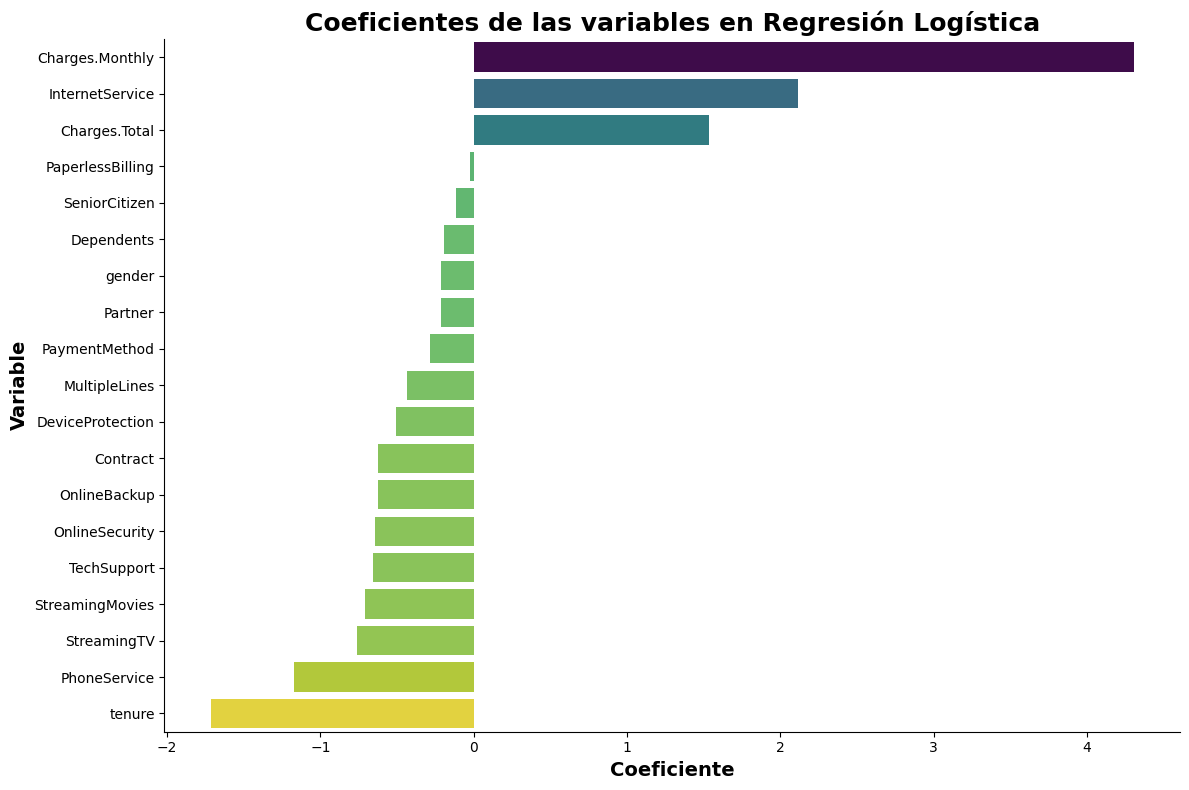

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener los coeficientes del modelo de Regresión Logística
logreg_coef = pd.DataFrame(
    {'feature': X_train.columns, 'coefficient': logreg.coef_[0]}
).sort_values('coefficient', ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x='coefficient',
    y='feature',
    data=logreg_coef,
    palette='viridis_r',  # Usamos la paleta invertida para que los coeficientes más altos tengan el color más oscuro
    hue='coefficient',      # Mantenemos el argumento 'hue' para evitar la advertencia
    legend=False            # Ocultamos la leyenda
)

# Eliminar las líneas superior y derecha del gráfico
sns.despine(top=True, right=True)

# Poner en negrita solo el título y los nombres de los ejes
ax.set_title('Coeficientes de las variables en Regresión Logística', fontsize=18, fontweight='bold')
ax.set_xlabel('Coeficiente', fontsize=14, fontweight='bold')
ax.set_ylabel('Variable', fontsize=14, fontweight='bold')

plt.tight_layout()
# Guardar el gráfico como un archivo PNG
plt.savefig('coeficientes_regresion_logistica.png')
plt.show()


#**Análisis de la importancia de las Variables Clave**

El análisis de la importancia de las variables revela los factores más influyentes en la decisión de un cliente de cancelar el servicio.
Tanto el Random Forest como la Regresión Logística señalan que las variables relacionadas con los costos y el tiempo de servicio son las más determinantes.

**Charges.Monthly y Charges.Total**:
Estas dos variables están directamente relacionadas.
El Random Forest les da la mayor importancia, y en el modelo de Regresión Logística, tienen los coeficientes positivos más altos.

El alto valor de los coeficientes positivos indica que, a medida que los cargos mensuales y el gasto total de un cliente aumentan,
también lo hace la probabilidad de que cancele. Esto sugiere que los clientes son sensibles al precio y que un aumento en el costo
o un alto costo acumulado puede ser un factor decisivo para buscar alternativas más económicas.

**tenure (Tiempo de contrato)**:
Esta variable es la tercera más importante para el Random Forest.
El análisis de los coeficientes de la Regresión Logística, revela un coeficiente negativo para esta variable.
Esto significa que a medida que un cliente permanece más tiempo con la empresa, la probabilidad de que cancele disminuye.
Los clientes a largo plazo suelen ser más leales y menos propensos a cambiar de proveedor.

**Contract (Tipo de contrato)**:
Es la cuarta variable más importante según el Random Forest.
El tipo de contrato se relaciona directamente con la permanencia.
Los clientes con contratos de mes a mes tienen una mayor flexibilidad para cancelar, lo que se traduce en una mayor probabilidad de abandono.
En cambio, aquellos con contratos a largo plazo (uno o dos años) tienen un compromiso contractual que reduce significativamente el riesgo
de cancelación.

**InternetService (Servicio de Internet)**:
Esta variable es la segunda con el coeficiente positivo más alto en la Regresión Logística.
Un coeficiente positivo alto indica que ciertos tipos de servicio de Internet (como la fibra óptica) pueden aumentar la probabilidad de
cancelación, quizás debido a una mayor competencia en el mercado o a expectativas de servicio más altas que no se cumplen.
Por otro lado, la falta de un servicio de Internet (por ejemplo, clientes con solo servicio telefónico) puede reducir la probabilidad de cancelación.

#**Informe de Análisis Predictivo y Estrategias de Retención de Clientes**
##**1. Resumen Ejecutivo**
El objetivo de este proyecto fue identificar los factores clave que impulsan la cancelación de clientes y desarrollar modelos predictivos para anticipar este comportamiento. Se evaluaron tres modelos de clasificación: Árbol de Decisiones, Random Forest y Regresión Logística. El modelo de Regresión Logística demostró ser el más efectivo para el negocio, ya que, a pesar de no tener la precisión general más alta, fue el mejor para identificar a los clientes en riesgo de cancelación.

##**2. Evaluación del Rendimiento de los Modelos**
Se evaluó el rendimiento de los modelos con métricas de clasificación y matrices de confusión.

**Regresión Logística**:
Este modelo fue el más exitoso en minimizar los Falsos Negativos (FN). Identificó correctamente a 252 clientes que cancelaron, mientras que solo falló en predecir la cancelación de 120 clientes. Minimizar los falsos negativos es crucial para el negocio, ya que permite a la empresa reaccionar y retener a los clientes que de otro modo se perderían.

**Random Forest**:
Aunque tuvo un rendimiento general sólido, su tasa de Falsos Negativos (147) fue mayor que la de la Regresión Logística, lo que lo hace menos deseable para la tarea de retención.

**Árbol de Decisiones**:
Este modelo fue el menos preciso, con el número más alto de Falsos Negativos (169).

##**3. Análisis de Factores de Riesgo de Cancelación**
El análisis de la importancia de las variables revela que la cancelación está impulsada por factores económicos y de servicio.

**Charges.Monthly y Charges.Total**:
Estas son las variables más influyentes en ambos modelos. En la Regresión Logística, sus coeficientes positivos son los más altos, lo que indica que a mayor gasto, mayor es la probabilidad de que un cliente cancele.

**Tenure (Tiempo de Permanencia)**:
Esta variable es muy importante para el modelo de Random Forest. El análisis de la Regresión Logística muestra que un mayor tiempo de permanencia disminuye la probabilidad de cancelación.

**Contract (Tipo de Contrato)**:
El tipo de contrato también es un factor determinante. Los clientes con contratos de corto plazo (Month-to-month) tienen una mayor flexibilidad para cancelar, lo que aumenta el riesgo de abandono.

**InternetService (Servicio de Internet)**:
Esta variable tiene un coeficiente positivo significativo en el modelo de Regresión Logística. Esto sugiere que ciertos tipos de servicio de internet (como la fibra óptica) están asociados a una mayor probabilidad de cancelación, posiblemente debido a la alta competencia.

##**4. Estrategias de Retención Propuestas**
Basándose en los factores de riesgo identificados, se proponen las siguientes estrategias para mitigar la cancelación de clientes:

**Revisión de Precios**:
Dado que Charges.Monthly y Charges.Total son los principales impulsores de la cancelación, se recomienda ofrecer descuentos personalizados o planes de precios más competitivos a los clientes de alto riesgo.

**Programas de Lealtad**:
Para los clientes con poca permanencia (tenure), se pueden crear programas de lealtad que recompensen el compromiso a largo plazo. Por ejemplo, ofrecer beneficios adicionales o precios reducidos a partir de un año de servicio.

**Incentivos para Contratos a Largo Plazo**:
Se pueden ofrecer beneficios exclusivos para los clientes que firmen contratos de uno o dos años, como un descuento significativo en el costo del servicio o meses gratis.

**Mejora del Servicio**:
Ya que el InternetService es un factor de riesgo, se deben monitorear proactivamente la calidad del servicio, la velocidad de conexión y el soporte técnico para reducir la insatisfacción del cliente.

Victoria Godoy - Analista Junior de Machine Learning